# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
# import caffeine
from datetime import datetime
import logging, os
from numba import njit, jit

## Daily Python Zen

In [3]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Set logger to log caching activity

In [4]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Version of 21cmFAST

In [5]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.0.dev5


## Number of cores running

In [6]:
print(f'Number of threads running = {os.cpu_count()}')

Number of threads running = 16


## Reset cache location 

In [7]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Gaussian function

In [8]:
@njit
def Gaussian(x):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-x**2)
    return Gaussian

## Measure the distance of each voxel to the center

In [9]:
@jit
def distance_from_coordinate(box_length):
        
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [10]:
def random_cube_regions(box_length, number_of_coordinates, radius):
    
    np.random.seed()  # no entry: set seed to a randome number
#     np.random.seed(4)  # specifying seed for testing purposes

    coordinates = np.random.randint(0, box_length, size=(number_of_coordinates, 3))
    
    # cube indices 
    inds1 = (coordinates-radius).astype(int)
    inds2 = (coordinates+radius+1).astype(int)  # ending index is not inclusive
    

    return inds1, inds2

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [11]:
def slicing_the_cube(ind1, ind2, radius, box):
        
    if ind1[0] < 0:  # periodic boundary conditions
        x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
    elif ind2[0] > len(box):
        x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
    else:
        x_inds = np.r_[ind1[0]:ind2[0]]

    if ind1[1] < 0:
        y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
    elif ind2[1] > len(box):
        y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
    else:
        y_inds = np.r_[ind1[1]:ind2[1]]

    if ind1[2] < 0:
        z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
    elif ind2[2] > len(box):
        z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
    else:
        z_inds = np.r_[ind1[2]:ind2[2]]
            
    indices = np.ix_(x_inds, y_inds, z_inds)
        
    try:
        output_box = box[indices]
        
    except IndexError:  # sample region larger than box.
        print(f'coordinate array = {ind1 + radius}')
        print(f'radius = {radius}')
        print(f'box length = {len(box)}')
        print(f'x_ind1 = {ind1[0]}')
        print(f'x_ind2 = {ind2[0]}')
        print(f'x_inds = {x_inds}')
        print(f'y_ind1 = {ind1[1]}')
        print(f'y_ind2 = {ind2[1]}')
        print(f'y_inds = {y_inds}')
        print(f'z_ind1 = {ind1[2]}')
        print(f'z_ind2 = {ind2[2]}')
        print(f'z_inds = {z_inds}')
        
    return output_box

## Gausssian Sphere Averaging

In [12]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = np.zeros(shell_num)

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    # sigma_factor number of sigmas the weighting goes out to, sigma = radius
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor 
    weight = Gaussian(x=shell_center)
    
    for ii in range(shell_num):
        condition = np.logical_and(
            distance_box <= shell_radius_edges[ii+1]*radius, 
            distance_box > shell_radius_edges[ii]*radius
        )
        inside_shell_mean = np.mean(input_box[condition])
        mean[ii] = inside_shell_mean
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [13]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [14]:
@njit
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Make sure averaging region size is not larger than the box itself 

In [15]:
def check_averaging_radius_limit(averaging_radius, box_length):
    # check to see if averaging region is larger than the box itself
    if averaging_radius > (box_length-1)/2:
        raise ValueError(f'Averaging_radius = {averaging_radius} > {(box_length-1)/2} = (Box Length-1)/2, \
averaging region is larger than the box itself.')

## Sphere Blurring Function

In [16]:
@jit
def Average_Neutral_Fraction_Distribution(
    box, 
    radius, 
    iteration, 
    shell_num=6, 
    sigma_factor=1.4370397097748921*3, 
    blur_shape=None
):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = np.zeros(iteration)  # empty list for data collection
    
    
    if blur_shape == 'Gaussian_sphere':
        
        
# ====================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  
            # 13/4 --> speculated correction factor
# ====================================================================================================================

        
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))
            
        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(len(box), iteration, radius)  

        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                radius, 
                box
            )
            mean = gaussian_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box, 
                shell_num, 
                sigma_factor
            )
            mean_data[i] = mean
        
    elif blur_shape == 'top_hat_sphere':
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))
            
        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(len(box), iteration, radius)  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                radius, 
                box
            )
            mean = top_hat_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box
            )
            mean_data[i] = mean
            
    elif blur_shape == 'top_hat_cube':
                
        # ratio determiend by equating the volumes of cube & sphere
        radius = int(round((radius*((4*np.pi/3)**(1/3))-1)/2))  

        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))

        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(len(box), iteration, radius)  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                radius, 
                box
            )
            mean = top_hat_cube_average(cube_region_box)
            mean_data[i] = mean
    else:
        
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells \
              weighted by equally spaced values from 0 sigma to 4 sigma.')
                
        
# ====================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  
            # 13/4 --> speculated correction factor
# ====================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))

        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)

        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(len(box), iteration, radius)  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                radius, 
                box
            )
            mean_data[i] = gaussian_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box, 
                shell_num, 
                sigma_factor
            )
            mean_data[i] = mean
            
    return mean_data

## Histogram Function

In [17]:
def histogram(
    y1s, 
    figure_shape, 
    y2s=None,
    y3s=None,
    marker_lines=None,
    y1s_labels=None,
    y2s_label=None,
    y3s_label=None,
    title=None, 
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    x_start=0, 
    x_stop=1, 
    bin_num=int(1e3), 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):  # a: x start, b: x stop
    
    bin_edges = np.linspace(x_start, x_stop, bin_num) # bin_num of bins from 0-1
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    if np.array(y1s).ndim > 2:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=share_x_axis, 
            sharey=share_y_axis, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
            dpi=dpi
        )
        
        if shared_title != None:
            
            fig.suptitle(
                x=shared_title_x_position, 
                y=shared_title_y_position, 
                t=shared_title, ha='center', 
                size=1.5*font_size, 
                color=color
            )
            
        if shared_x_label != None:  # shared x label
            fig.text(
                x=shared_x_label_x_position, 
                y=shared_x_label_y_position, 
                s=shared_x_label, ha='center', 
                size=font_size, 
                color=color
            )

        if shared_y_label != None:  # shared y label
            fig.text(
                x=shared_y_label_x_position, 
                y=shared_y_label_y_postion, 
                s=shared_y_label, 
                va='center', 
                rotation='vertical', 
                size=font_size, 
                color=color
            )
        
        for i, y1 in enumerate(y1s):
            
            for ii, marker_line in enumerate(marker_lines):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y1s[i,ii,:], bins=bin_edges)[0], 
                    marker_line,
                    label=y1s_labels[ii]
                )
            
            if iterable(y2s):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y2s[i], bins=bin_edges)[0], 
                    '--', 
                    label=y2s_label
                )
                
                if iterable(y3s):
                    axes.flatten()[i].plot(
                        bin_centers, 
                        np.histogram(y3s[i], bins=bin_edges)[0], 
                        label=y3s_label
                    )
                    
                    
            if y1s_labels != None:
                axes.flatten()[i].legend()
                
            if title != None:
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
                
            axes.flatten()[i].set_yscale(y_scale)
            
            if y_notation == 'sci':
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation, 
                    scilimits=(0,0), 
                    useMathText=True
                )
                
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style

            for spine in axes.flatten()[i].spines.values():  # figure color
                spine.set_edgecolor(color)
                
    else:
        
        fig, ax = plt.subplots(figsize=figure_size)
        
        ax.plot(bin_centers, np.histogram(y1s, bins=bin_edges)[0], label=y1s_labels)
        
        if y2s != None:
            ax.plot(bin_centers, np.histogram(y2s, bins=bin_edges)[0], '--', label=y2s_label)
            
            if y3s == None:
                ax.legend()
                
            else:
                ax.plot(bin_centers, np.histogram(y3s, bins=bin_edges)[0], '-.', label=y3s_label)
                ax.legend()
                
        if title != None:
            ax.set_title(title, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)
        
        if y_notation == 'sci':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # font style

        for spine in ax.spines.values():  # figure color
            spine.set_edgecolor(color)
            
    plt.show()

## Check if object is iterable

In [18]:
def iterable(obj):
    
    try:
        iter(obj)
        
    except Exception:
        return False
    
    else:
        return True

## MFP alternate neutral region size measurement

In [19]:
from scipy import interpolate
def mfp(data, xth=0.5, boxsize=None, iterations = 10000000, verbose=True, upper_lim=False, bins=None, r_min=None, r_max=None):
    """
    Determines the sizes using the Mean-Free-Path (MFP) approach.

    Parameters
    ----------
    input     : ndarray
        2D/3D array of ionization fraction/brightness temperature.
    xth       : float
        The threshold value (Default: 0.5).
    boxsize   : float
        The boxsize in cMpc can be given (Default: conv.LB).
    iterations: float
        Number of iterations (Default: 1e7).
    verbose   : bool
        It prints the progress of the program (Default: True).
    upper_lim : bool
        It decides if the threshold is the upper limit or the lower limit (Default: False).
    bins      : int
        Give number of bins or an array of sizes to re-bin into (Default: None).
    r_min     : float
        Minimum size after rebinning (Default: None).
    r_max     : float
        Maximum size after rebinning (Default: None).

    Returns
    -------
    r  : ndarray
        sizes of the regions
    dn : ndarray
        probability of finding the corresponding size 
    """
    if boxsize is None:
        boxsize = conv.LB
        print('Boxsize is set to %.2f Mpc.'%boxsize) 
    dim = len(data.shape)
    t1 = datetime.now()
    if (upper_lim): 
        data = -1.*data
        xth  = -1.*xth
    check_box = (data>=xth).sum()
    if check_box==0:
        data = np.ones(data.shape)
        iterations = 3
    if dim == 2:
        print("MFP method applied on 2D data (ver 1.0)")
        #out = mfp2d(data, xth, iterations=iterations, verbose=verbose)
        out = mfp2d(data, xth, iterations=iterations, verbose=verbose)
    elif dim == 3:
        print("MFP method applied on 3D data (ver 1.0)")
        #out = mfp3d(data, xth, iterations=iterations, verbose=verbose)
        out = mfp3d(data, xth, iterations=iterations, verbose=verbose)
    else:
        print("The data doesn't have the correct dimension")
        return 0
    nn = out[0]/iterations
    rr = out[1]
    t2 = datetime.now()
    runtime = (t2-t1).total_seconds()/60

    print("\nProgram runtime: %f minutes." %runtime)
    if check_box==0:
        print("There is no ROI in the data. Therefore, the BSD is zero everywhere.")
        return rr*boxsize/data.shape[0], np.zeros(rr.shape)
    print("The output contains a tuple with three values: r, rdP/dr")
    print("The curve has been normalized.")
  
    r0,p0 = rr*boxsize/data.shape[0], rr*nn #rr[nn.argmax()]*boxsize/data.shape[0]
    if bins is not None: r0,p0 = rebin_bsd(r0, p0, bins=bins, r_min=r_min, r_max=r_max)
    return r0, p0

def rebin_bsd(rr, pp, bins=10, r_min=None, r_max=None):
    fp = interpolate.interp1d(rr, pp, kind='cubic')
    if np.array(bins).size == 1:
        if r_min is None: r_min = rr.min()+1
        if r_max is None: r_max = rr.max()-10
        rs = 10**np.linspace(np.log10(r_min), np.log10(r_max), bins)
    else: rs = np.array(bins)
    return rs, fp(rs)


## MFP3D & 2D

In [20]:
from scipy.interpolate import RegularGridInterpolator
import sys

def mfp3d(arr, xth=0.5, iterations=10000000, verbose=True):
    #3D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info = arr.shape  # dimentions of the data box

#=========================================================================================================
    longest = int(max(arr.shape)*np.sqrt(3))  # longest distance between 2 points in the box, i.e. diagonal corners
    # EDIT: switch the definition of longest to sqrt(3)*longest
#=========================================================================================================
    
    num_sz  = np.zeros(longest)  # place holder with length of the longest axis

    ar  = np.zeros(arr.shape)  # place holder with data box shape
    ar[arr >= xth] = 1  # generating a binary box, xth = threshold

    loc = np.argwhere(ar == 1)  # locations of ionized cells
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)  # iterations number of random ionized locations
 
    #==================================================================================
    thetas   = np.random.randint(0, 180, size=iterations)  # should it be 0 to 180 deg?
    # EDIT: switched upper limit from 360 to 180.
    #==================================================================================

    phis     = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)*np.cos(phis*np.pi/180)  # dx
    ms       = np.sin(thetas*np.pi/180)*np.sin(phis*np.pi/180)  # dy
    ns       = np.cos(thetas*np.pi/180)  # dz
    xs,ys,zs = loc[rand_loc,0],loc[rand_loc,1],loc[rand_loc,2]  # slicing ionized locations with [randome coordinate, (x,y,z)]

    interp_func = RegularGridInterpolator((np.arange(info[0]), np.arange(info[1]), np.arange(info[2])), ar, bounds_error=False, fill_value=0)

    #=========================================================================================================
    for rr in range(longest):  # steping 1 step along the ray for all directions.
    # should it be sqrt(longestX^2, longestY^2, longestZ^2)?
    # motivation: no rays will be longer than the longest axis?
    # EDIT: switch the definition of longest to sqrt(3)*longest
    #=========================================================================================================

        xs,ys,zs = xs+ls,ys+ms,zs+ns  # steping by dx, dy, dz
        pts    = np.vstack((xs,ys,zs)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)  # coordinates that are outsise ionized regions.
        num_sz[rr] = check.shape[0]  # record the number of new rays terminated in this loop
        xs,ys,zs = np.delete(xs, check),np.delete(ys, check),np.delete(zs, check)  # for the terminated rays,
        ls,ms,ns = np.delete(ls, check),np.delete(ms, check),np.delete(ns, check)  # delete the forward step 
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
    size_px = np.arange(longest)
    return num_sz, size_px

def mfp2d(arr, xth=0.5, iterations=1000000, verbose=True):
    #2D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info    = arr.shape
    longy	= max([info[0], info[1]])
    longest = int(np.sqrt(2)*longy)
    num_sz  = np.zeros(longest)

    ar  = np.zeros(arr.shape)
    ar[arr >= xth] = 1

    loc = np.argwhere(ar == 1)
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)
    thetas   = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)
    ms       = np.cos(thetas*np.pi/180)

    xs,ys    = loc[rand_loc,0],loc[rand_loc,1]

    interp_func = RegularGridInterpolator((np.arange(info[0]), np.arange(info[1])), ar, bounds_error=False, fill_value=0)

    for rr in range(longest):
        xs,ys  = xs+ls,ys+ms
        pts    = np.vstack((xs,ys)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)
        num_sz[rr] = check.shape[0]
        xs,ys  = np.delete(xs, check),np.delete(ys, check)
        ls,ms  = np.delete(ls, check),np.delete(ms, check)
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
    size_px = np.arange(longest)
    return num_sz, size_px


def loading_verbose(string):
    msg = ("Completed: " + string )
    sys.stdout.write('\r'+msg)
    sys.stdout.flush()

## Cosmological Parameters (Default is used when no input is specified)

In [21]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [22]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [23]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-07-29 12:16:39.992346


2020-07-29 12:18:25,685 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-07-29 12:18:25.687195
Execution time = 0:01:45.694849


## Generate ionized boxes as a function of redshift

In [24]:
redshifts = np.arange(8.5, 4, -0.5)

    # temporary
# ====================================================================================================================
# redshifts = np.array([6.5])
# ====================================================================================================================

ionized_boxes = np.zeros((len(redshifts), HII_DIM, HII_DIM, HII_DIM))

for i, z in enumerate(redshifts):
    ionized_box = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box
    ionized_boxes[i] = ionized_box

2020-07-29 12:18:27,431 | INFO | Existing z=8.5 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:29,218 | INFO | Existing z=8.0 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:31,089 | INFO | Existing z=7.5 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:33,048 | INFO | Existing z=7.0 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:35,328 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:36,983 | INFO | Existing z=6.0 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:38,766 | INFO | Existing z=5.5 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:40,433 | INFO | Existing z=5.0 ionized boxes found and read in (seed=230806296593).
2020-07-29 12:18:42,762 | INFO | Existing z=4.5 ionized boxes found and read in (seed=230806296593).


## Generate Average Neutral Fraction Distributions as a function of redshift

In [ ]:
def generate_distributions(
    boxes=ionized_boxes,
    radii=np.arange(8, 17, 1),
    iterations=10**2,
    sigma_factor=1.4370397097748921*3,
    shell_number=6,
    progress_status=True
):

    gaussians = np.zeros((len(redshifts), len(radii), iterations))
    
    
    # temporary
# ====================================================================================================================
#     cubes = np.zeros((len(radii), iterations))
# ====================================================================================================================

    
    if progress_status:
        # print progress and local time
        start_time = datetime.now()
        current_time = start_time
        print(f'Progress = 0%, localtime = {start_time}')

    for i, box in enumerate(boxes):
        
    # temporary
# ====================================================================================================================
#         cube = Average_Neutral_Fraction_Distribution(
#                 box=boxes[0],
#                 radius=radius,
#                 iteration=iterations,
#                 blur_shape='top_hat_cube'
#         )
        
#         cubes[i, :] = cube
# ====================================================================================================================
        
        for ii, radius in enumerate(radii):
                        
            gaussian = Average_Neutral_Fraction_Distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                sigma_factor=sigma_factor,
                shell_num=shell_number,
                blur_shape='Gaussian_sphere'
            )

            gaussians[i, ii, :] = gaussian


        if progress_status:
            # print progress and local time
            previous_time = current_time
            current_time = datetime.now()
            loop_time = current_time - previous_time
            elapsed_time = current_time - start_time
            print(f'progress = {int(round((i+1)*100/len(boxes)))}%, \
localtime = {current_time}, loopexecuted in {loop_time}, elapsedtime = {elapsed_time}')
        
    # temporary
# ====================================================================================================================
#     return gaussians, cubes
# ====================================================================================================================
    
    return gaussians

## Generate the distributions and storing the data in global variables

In [ ]:
radii = np.arange(9, 1, -1)  # array([34, 32, 30,... 6, 4]) units: voxels (51, 3, -3)
iterations = int(3*7.5e4)
    # temporary
# =================================================================================================================== 
# gaussians, cubes = generate_distributions(
# =================================================================================================================== 

gaussians = generate_distributions(
    boxes=ionized_boxes,
    radii=radii,
    iterations=iterations,
    sigma_factor=1.4370397097748921*3
)

## Creating Histogram

In [ ]:
bins = int(3e2)
histogram(
    y1s=gaussians, 
    
    # temporary
# =================================================================================================================== 
#     y2s=cubes,
# =================================================================================================================== 
    
    marker_lines=['-']*len(radii),
    y1s_labels=[f'Radius={r*BOX_LEN/HII_DIM:.0f}Mpc' for r in radii],
    bin_num=bins,
    
    # temporary
# =================================================================================================================== 
#     y2s_label='Cube',
# =================================================================================================================== 
    
    title=[f'Redshift={z}' for z in redshifts],
    shared_title=f'Distribution of Average Neutral Fraction \
(format switch r&z, {bins} bins, {iterations:.2e} iterations)',
    shared_y_label='Counts',
    shared_x_label='Neutral Fraction',
    figure_shape=(3,3), 
    figure_size=(18,18),
    vertical_gap=0.1,
    horizontal_gap=0.2,
    y_scale='log',
#     y_notation='sci',
    share_y_axis=False,
    dpi=1000
)

## Generating Neutral Region Size Distributions with mfp()

In [44]:
def MFP_distributions(
    boxes=ionized_boxes, 
    bins = int(1e3),
    iterations=int(1e3)
):
    mfp_radii = np.zeros(bins)
    mpf_radii_probabilities = np.zeros((len(redshifts), bins))
    for i, box in enumerate(boxes):
        mfp_radii, mpf_radii_probabilities[i, :] = mfp(
            data=box,
            boxsize=BOX_LEN,
            iterations=iterations,
            verbose=True, 
            upper_lim=False, 
            bins=bins, 
            r_min=None, 
            r_max=None
        )
    return mfp_radii, mpf_radii_probabilities

In [64]:
bin_num = int(1e3)
start_time = datetime.now()
print(f'Run started at {start_time}')
mfp_neutral_region_size, mfp_size_probabilities = MFP_distributions(
    boxes=ionized_boxes,
    bins=bin_num,
    iterations=int(5.75e7)
)
end_time = datetime.now()
print(f'Run completed at {end_time}')
print(f'Total runtime: {end_time - start_time}')

Run started at 2020-07-29 13:26:57.415451
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 18.432487 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 15.397239 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 12.946559 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 10.937265 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 9.286156 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed

In [61]:
np.sum([3.002065, 2.496590, 2.099125, 1.763665, 1.482579, 1.235962, 0.996028, 0.806197, 0.577417])

14.459628

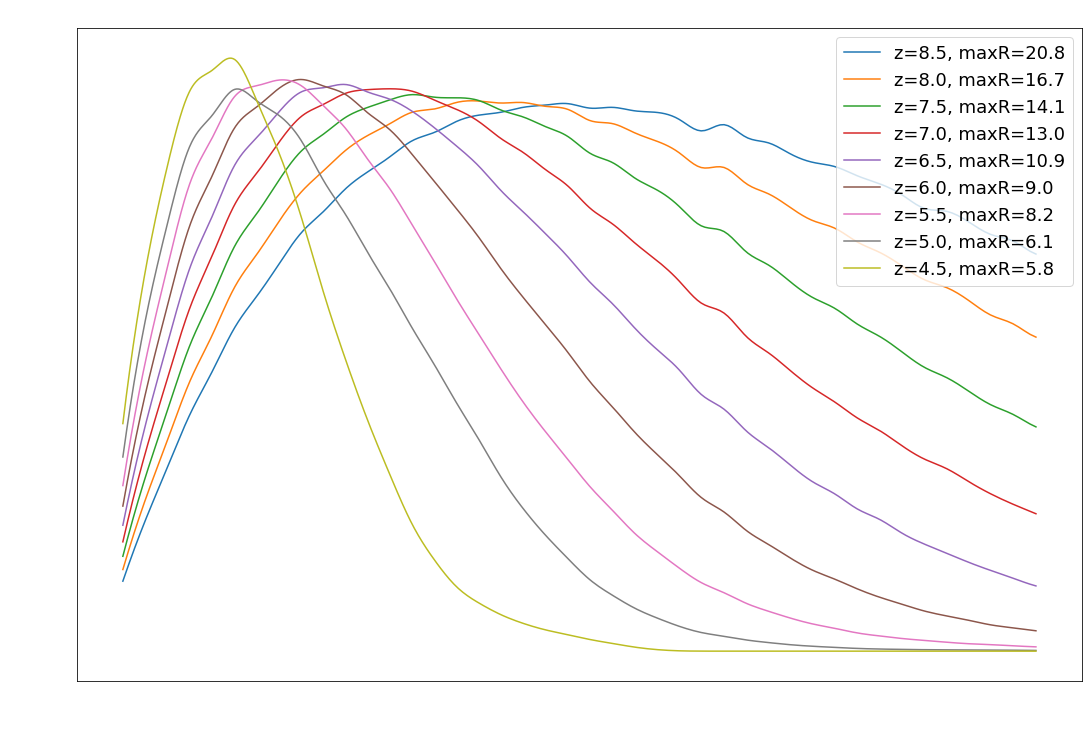

In [65]:
color='white'
percent=0.6

plt.figure(figsize=(18, 12))
for i, mfp_size_probabilitie in enumerate(mfp_size_probabilities):
    plt.plot(
        mfp_neutral_region_size[:int(percent*bin_num)], 
        mfp_size_probabilitie[:int(percent*bin_num)], 
        '-',
        label=f'z={redshifts[i]}, maxR={mfp_neutral_region_size[np.argmax(mfp_size_probabilities[i])]:.1f}'
    )
plt.legend()
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$R$ (Mpc)', color=color)
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$', color=color)
plt.title(f'Region Size Distribution of Neutral Fraction Box', color=color)
plt.rcParams['font.size'] = 18
# plt.yscale('log')

In [31]:
mfp_neutral_region_size[np.argmax(mfp_size_probabilities[0])]

20.888467671861488

In [60]:
for i in range(mfp_neutral_region_sizes.shape[0]):
    print(np.all(mfp_neutral_region_sizes[1, :]==mfp_neutral_region_size))

True
True
True
True
True
True
True
True
True


In [43]:
mfp_neutral_region_sizes.shape

(9, 1000)